In [1]:
import os
import time
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.transforms import transforms
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist
from scipy.io import loadmat

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Model 

In [4]:
convNext = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)


class ConvNext_Tiny_Backbone(nn.Module):

    def __init__(self):
        super().__init__()
    
    
    def forward(self, x):   
        x = convNext.features[0](x)
        x = convNext.features[1](x) # 96
        x = convNext.features[2](x)
        x = convNext.features[3](x) # 192
        F1 = x

        x = convNext.features[4](x)
        x = convNext.features[5](x) # 384
        F2 = x

        x = convNext.features[6](x)
        x = convNext.features[7](x) # 768
        F3 = x

        return F1, F2, F3       

In [5]:
class DynamicConvLayer(nn.Module):
    """
    Implements a single dynamic convolution layer (Y(X) from Equation 2)
    with dynamic kernel generation and application, explicitly modulated
    by input (Aik) and output (Aok) channel attention factors.
    It predicts a 1x1 convolution kernel.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = 1 # As per Figure 3 and common dynamic conv usage (1x1 conv)

        # 1. Attention generation for kernel modulation (A(X) from Equation 1)
        # Outputs attention factors for Aik (in_channels) and Aok (out_channels).
        self.attention_generator = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), # AvgPool(X)
            nn.Flatten(),
            nn.Linear(in_channels, in_channels // 8), # FC
            nn.ReLU(),
            # Output for Aik (in_channels length) and Aok (out_channels length)
            nn.Linear(in_channels // 8, self.in_channels + self.out_channels),
            nn.Sigmoid() # sigma
        )

        # 2. Dynamic Kernel Prediction Network (P_kernel(X))
        # This network takes global pooled features and predicts the 1x1 convolution kernel weights.
        # For a 1x1 convolution, the kernel shape is (out_channels, in_channels, 1, 1).
        self.kernel_predictor = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_channels, in_channels // 8),
            nn.ReLU(),
            nn.Linear(in_channels // 8, self.out_channels * self.in_channels * self.kernel_size * self.kernel_size)
        )

        # BatchNorm and ReLU (as per paper's FTM general description)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        N, C, H, W = x.shape # Batch, Channels, Height, Width

        # Generate attention factors (Aik, Aok)
        att_factors_raw = self.attention_generator(x) # (N, in_channels + out_channels)
        # Aik_factors needs to broadcast with in_channels dimension of kernel: (N, 1, in_C, 1, 1)
        Aik_factors = att_factors_raw[:, :self.in_channels].view(N, 1, self.in_channels, 1, 1)
        # Aok_factors needs to broadcast with out_channels dimension of kernel: (N, out_C, 1, 1, 1)
        Aok_factors = att_factors_raw[:, self.in_channels:].view(N, self.out_channels, 1, 1, 1)

        # Predict raw kernel weights
        # Reshape to (N, out_channels, in_channels, kernel_h, kernel_w)
        predicted_kernel_raw = self.kernel_predictor(x).view(
            N, self.out_channels, self.in_channels, self.kernel_size, self.kernel_size
        )

        # Modulate the predicted kernels with attention factors (element-wise multiplication as per Equation 2)
        modulated_kernel = predicted_kernel_raw * Aik_factors * Aok_factors

        # Reshape input X: (N, C, H, W) -> (1, N*C, H, W) for grouped convolution
        x_reshaped = x.view(1, N * C, H, W)

        # Reshape modulated_kernel for group convolution
        # From (N, Cout, Cin, K, K) to (N*Cout, Cin, K, K)
        kernel_for_conv = modulated_kernel.view(
            N * self.out_channels, self.in_channels, self.kernel_size, self.kernel_size
        )

        # Perform grouped convolution (groups=N)
        # This applies a different kernel for each sample in the batch.
        conv_output_reshaped = F.conv2d(
            x_reshaped,
            kernel_for_conv,
            stride=1,
            padding=0,
            dilation=1,
            groups=N # Crucial for applying per-sample kernel
        )

        # Reshape back to (N, Cout, H, W)
        conv_output = conv_output_reshaped.view(N, self.out_channels, H, W)

        # Apply BatchNorm and ReLU
        P_intermediate = self.relu(self.bn(conv_output))

        return P_intermediate


class DynamicConvBlock(nn.Module):
    """
    A block combining DynamicConvLayer with BatchNorm and ReLU activation,
    used in the stacked dynamic convolutions of the FTM.
    This block is designed to preserve channel dimensions (in_channels == out_channels).
    """
    def __init__(self, channels: int):
        super(DynamicConvBlock, self).__init__()
        # DynamicConvLayer now correctly handles in_channels to out_channels mapping.
        # For this block, in_channels == out_channels == channels.
        self.dyconv = DynamicConvLayer(channels, channels)
        self.bn = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for DynamicConvBlock.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after dynamic convolution, BatchNorm, and ReLU.
        """
        return self.relu(self.bn(self.dyconv(x)))


class FocusTransitionModule(nn.Module):
    """
    Implements the Focus Transition Module (FTM) from the Fuss-Free Network.
    This module performs channel feature weight optimization, stacked dynamic
    convolutions with residual connections, spatial feature weight optimization,
    and a final dimensionality reduction.
    """
    def __init__(self, in_channels: int, out_channels: int, num_stacked_dynamic_convs: int = 4):
        """
        Initializes the FocusTransitionModule.

        Args:
            in_channels (int): Number of input channels from the backbone.
            out_channels (int): Desired number of output channels for the FTM.
            num_stacked_dynamic_convs (int): Number of stacked DynamicConvBlocks
                                              in the P(C) component. Defaults to 4
                                              as suggested by the nesting in formula (4).
        """
        super(FocusTransitionModule, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_stacked_dynamic_convs = num_stacked_dynamic_convs

        # 1. Channel Feature Weight Optimization C(F) (Equation 3)
        # C(F) = sigma(MLP(AvgPool(F))) .dot. F
        # MLP is implemented as Linear layers on global average pooled features.
        self.channel_attn_mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Global Average Pooling
            nn.Flatten(),            # Flatten to prepare for Linear layers
            nn.Linear(in_channels, in_channels // 4), # First FC (reduces channels)
            nn.ReLU(),               # ReLU activation
            nn.Linear(in_channels // 4, in_channels), # Second FC (restores channels)
            nn.Sigmoid()             # Sigmoid activation as per formula (3)
        )

        # 2. Stacked Dynamic Convolutions P(C) (Equation 4)
        # P(C) = Y[Y(Y(Y(C)+C)+(Y(C)+C))]
        # Implemented as a sequence of DynamicConvBlocks, each with a residual connection.
        # These blocks preserve channel dimensions (in_channels -> in_channels).
        self.dynamic_conv_layers = nn.ModuleList()
        for _ in range(num_stacked_dynamic_convs):
            self.dynamic_conv_layers.append(DynamicConvBlock(in_channels))

        # 3. Spatial Feature Weight Optimization S(P) (Equation 5)
        # S(P) = sigma(Conv(mean(P))) .dot. P
        # mean(P) is channel-wise mean, resulting in (B, 1, H, W).
        # Conv maps 1 channel to in_channels to match P for element-wise multiplication.
        self.spatial_attn_conv = nn.Conv2d(1, in_channels, kernel_size=1)
        self.spatial_attn_sigmoid = nn.Sigmoid()

        # Final 1x1 convolution for dimensionality reduction
        # This layer performs the reduction from in_channels to out_channels for the FTM.
        self.final_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for FocusTransitionModule.

        Args:
            x (torch.Tensor): Input feature map from the backbone (F in paper's formulas).
                              Shape (B, in_channels, H, W).

        Returns:
            torch.Tensor: Output feature map after FTM processing.
                          Shape (B, out_channels, H_out, W_out).
        """
        # --- Step 1: Channel Feature Weight Optimization C(F) ---
        # Calculate channel attention weights: (B, in_channels) then unsqueeze to (B, in_channels, 1, 1)
        channel_attention_weights = self.channel_attn_mlp(x).unsqueeze(-1).unsqueeze(-1)
        # Apply element-wise multiplication: C(F) = sigma(MLP(AvgPool(F))) * F
        f_c = x * channel_attention_weights

        # --- Step 2: Stacked Dynamic Convolutions P(C) ---
        # The input to this section is `f_c`.
        # Iteratively apply DynamicConvBlock with residual connections.
        p_intermediate = f_c
        for layer in self.dynamic_conv_layers:
            # Apply DynamicConvBlock and add residual connection (Y(X) + X)
            p_intermediate = layer(p_intermediate) + p_intermediate
        p_out = p_intermediate # This `p_out` is `P` in formula (5)

        # --- Step 3: Spatial Feature Weight Optimization S(P) ---
        # Compute channel-wise mean of P to get (B, 1, H, W)
        mean_p = p_out.mean(dim=1, keepdim=True)
        # Apply 1x1 conv to this mean to get spatial attention map (B, in_channels, H, W)
        spatial_attention_map = self.spatial_attn_conv(mean_p)
        # Apply sigmoid
        spatial_attention_map = self.spatial_attn_sigmoid(spatial_attention_map)
        # Element-wise multiplication: S(P) = sigma(Conv(mean(P))) * P
        s_out = p_out * spatial_attention_map

        # --- Step 4: Final 1x1 Convolution for Dimensionality Reduction ---
        final_output = self.final_conv(s_out)

        return final_output

In [10]:
img = Image.open("crowd_wala_dataset/train_data/images/IMG_1.jpg").convert("RGB")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img = transform(img)

# conv = ConvNext_Tiny_Backbone()
# focus1 = FocusTransitionModule(192, 16)
# focus2 = FocusTransitionModule(384, 32)
# focus3 = FocusTransitionModule(768, 64)
# fusion = MultiScaleFusion()

# f1, f2, f3 = conv(img.unsqueeze(0))
# s1 = focus1(f1)
# s2 = focus2(f2)
# s3 = focus3(f3)
# print(s1.shape, s2.shape, s3.shape)
# s = fusion(s1, s2, s3)
# print(s.shape)

output = model(img.unsqueeze(0))
print(output.shape)
print(output)

torch.Size([1, 1, 96, 128])
tensor([[[[-0.5372, -0.2730, -0.2030,  ..., -0.0593, -0.1990, -0.3364],
          [-0.3505, -0.3219,  0.1286,  ..., -0.0641, -0.2303, -0.2321],
          [-0.2842,  0.2952, -0.1441,  ..., -0.3001, -0.2204, -0.0942],
          ...,
          [-0.6826, -0.1410, -0.1477,  ..., -0.1408, -0.2651, -0.1452],
          [ 0.0907,  0.1410, -0.0077,  ..., -0.0053,  0.1263,  0.0011],
          [-0.0681, -0.0869, -0.2485,  ..., -0.0833, -0.1822, -0.1624]]]],
       grad_fn=<ConvolutionBackward0>)


In [6]:
class MultiScaleFusion(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.transpose2 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
        self.transpose3 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=4)

    
    def forward(self, s1, s2, s3):
        h, w = s1.shape[2], s1.shape[3]
        s2 = self.transpose2(s2)
        s3 = self.transpose3(s3)

        S = torch.cat([s1, s2, s3], dim=1)

        return S

In [7]:
class FFNet(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.backbone = ConvNext_Tiny_Backbone()
        self.focus1 = FocusTransitionModule(192, 16)
        self.focus2 = FocusTransitionModule(384, 32)
        self.focus3 = FocusTransitionModule(768, 64)
        self.fusion = MultiScaleFusion()

        self.conv = nn.Conv2d(112, 1, kernel_size=1)
    

    def forward(self, x):

        f1, f2, f3 = self.backbone(x)

        s1 = self.focus1(f1)
        s2 = self.focus2(f2)
        s3 = self.focus3(f3)

        S = self.fusion(s1, s2, s3)

        density_map = self.conv(S)

        return density_map

In [9]:
model = FFNet()
# model = model.to(device)

In [ ]:
# class FocusTransitionModule(nn.Module):
#     """
#     Implements the Focus Transition Module (FTM) as described in Figure 5
#     and equations (1) and (2) of the paper.
#     It combines channel-wise attention, dynamic convolution, and spatial attention.
#     """
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         # Channel-wise attention (C(F) in Equation 3)
#         self.channel_fc1 = nn.Linear(in_channels, in_channels // 4)
#         self.channel_relu = nn.ReLU()
#         self.channel_fc2 = nn.Linear(in_channels // 4, in_channels)
#         self.channel_sigmoid = nn.Sigmoid()

#         # Dynamic Convolution part (Y(X) in Equation 2, inspired by Dyconv paper)
#         # This is a simplified representation. A full dynamic convolution would involve
#         # predicting kernel weights. Here we use a more direct approach based on attention for simplicity.
#         self.dyconv_attention_fc = nn.Sequential(
#             nn.Linear(in_channels, in_channels // 8),
#             nn.ReLU(),
#             nn.Linear(in_channels // 8, 4 * in_channels), # Simplified: directly predict scaling factors for 4 attention dimensions
#             nn.Sigmoid()
#         )
#         self.dyconv_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) # Actual convolution

#         # Spatial feature weight optimization (S(P) in Equation 5)
#         self.spatial_conv = nn.Conv2d(out_channels, 1, kernel_size=1)
#         self.spatial_sigmoid = nn.Sigmoid()

#         # BatchNorm and ReLU after dynamic convolution
#         self.bn = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         # Input F (x)
#         # Channel feature weight optimization C(F)
#         avg_pool = F.adaptive_avg_pool2d(x, (1, 1)).squeeze(-1).squeeze(-1) # Global Average Pooling
#         channel_attention = self.channel_fc2(self.channel_relu(self.channel_fc1(avg_pool))).unsqueeze(-1).unsqueeze(-1)
#         channel_attention = self.channel_sigmoid(channel_attention)
#         F_prime = x * channel_attention # Element-wise multiplication

#         # Dynamic Convolution part P(C) (simplified)
#         # In the original paper, A(X) is computed for dynamic kernel generation.
#         # Here, we model the idea of dynamic adjustment of features.
#         N, C, H, W = F_prime.shape
#         dyconv_att_weights = self.dyconv_attention_fc(F.adaptive_avg_pool2d(F_prime, (1,1)).view(N,C)).view(N, 4, C)
#         Ank, Ask, Aik, Aok = dyconv_att_weights[:, 0, :].unsqueeze(-1).unsqueeze(-1), \
#                              dyconv_att_weights[:, 1, :].unsqueeze(-1).unsqueeze(-1), \
#                              dyconv_att_weights[:, 2, :].unsqueeze(-1).unsqueeze(-1), \
#                              dyconv_att_weights[:, 3, :].unsqueeze(-1).unsqueeze(-1)

#         # Apply channel-wise scaling based on dynamic attention, then 1x1 conv
#         dyconv_output_scaled = self.dyconv_conv(F_prime * Ank * Ask * Aik * Aok)

#         # Apply BatchNorm and ReLU (as per paper's description after dynamic conv)
#         P = self.relu(self.bn(dyconv_output_scaled))

#         # Spatial feature weight optimization S(P)
#         mean_P = torch.mean(P, dim=1, keepdim=True) # Mean value of P across channel dimension
#         spatial_attention = self.spatial_sigmoid(self.spatial_conv(mean_P))
#         S = P * spatial_attention # Element-wise multiplication

#         return S

# Dataset Pipeline

In [6]:
k_nearest = 3
beta = 0.3

def generate_density_map(img, points):

    img_width, img_height = img.size
    d_map_height = img_height // 8
    d_map_width = img_width // 8
    density_map = np.zeros((d_map_height, d_map_width), dtype=np.float32)
    
    if len(points) == 0:
        return density_map

    scaled_points = points / 8
    
    sigmas = []
    if len(scaled_points) > 1:
        distances = cdist(scaled_points, scaled_points)
        
        for i in range(len(scaled_points)):
            sorted_distances = np.sort(distances[i][distances[i] > 1e-6])
            
            if len(sorted_distances) >= k_nearest:
                d_k = sorted_distances[k_nearest - 1]
                sigma_i = beta * d_k
            else:
                sigma_i = beta * np.mean(sorted_distances) if len(sorted_distances) > 0 else 1.0
            sigmas.append(sigma_i)
    else:
        sigmas.append(4.0)
    
    sigmas = np.array(sigmas)
    
    for i, (x, y) in enumerate(scaled_points):
        if int(y) < d_map_height and int(x) < d_map_width:
            point_map = np.zeros_like(density_map)
            point_map[int(y), int(x)] = 1.0
            
            blurred_point_map = gaussian_filter(point_map, sigma=sigmas[i], mode='constant')

            density_map += blurred_point_map
    
    return density_map

In [7]:
class CustomDataset(Dataset):

    def __init__(self, img_folder_path, point_folder_path):
        self.img_folder_path = img_folder_path
        self.point_folder_path = point_folder_path
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


    def __len__(self):
        return(len(os.listdir(self.img_folder_path)))


    def __getitem__(self, index):
        img_path = os.path.join(self.img_folder_path, f"IMG_{index+1}.jpg")
        point_path = os.path.join(self.point_folder_path, f"GT_IMG_{index+1}.mat")

        img = Image.open(img_path).convert("RGB")

        data = loadmat(point_path)
        point = data["image_info"][0][0][0][0][0]

        density_map = generate_density_map(img, points=point.astype(int))
        density_map = torch.from_numpy(density_map).float().unsqueeze(0)

        img = self.transform(img)

        return img, density_map

In [8]:
train_dataset = CustomDataset("crowd_wala_dataset/train_data/images", "crowd_wala_dataset/train_data/ground_truth")
test_dataset = CustomDataset("crowd_wala_dataset/test_data/images", "crowd_wala_dataset/test_data/ground_truth")

In [9]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=4)

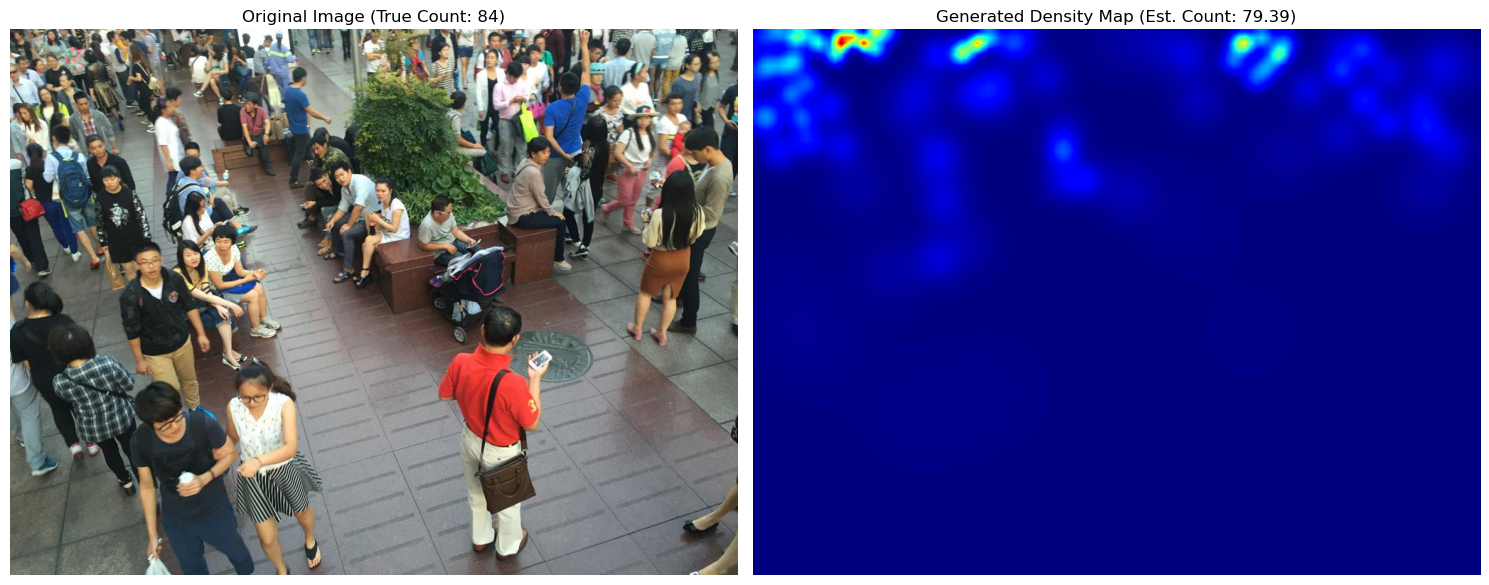

In [10]:
data = loadmat('crowd_wala_dataset/train_data/ground_truth/GT_IMG_40.mat')
point = data["image_info"][0][0][0][0][0]


img = Image.open("crowd_wala_dataset/train_data/images/IMG_40.jpg").convert("RGB")

density_map = generate_density_map(img, points=point.astype(int))
density_map_tensor = torch.from_numpy(density_map).float().unsqueeze(0).unsqueeze(0)

upsampled_density_map = torch.nn.functional.interpolate(
    density_map_tensor,
    size=(img.size[1], img.size[0]),
    mode='bilinear',
    align_corners=False).squeeze().cpu().numpy()


true_count = len(point)
estimated_count = np.sum(density_map)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f'Original Image (True Count: {true_count})')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(upsampled_density_map, cmap='jet')
plt.title(f'Generated Density Map (Est. Count: {estimated_count:.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()

# Loss Fxn

In [11]:
learning_rate = 0.0001
epochs = 100

loss_fxn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop

In [ ]:
start = time.time()
losses = []


for i in range(epochs):

    total_epoch_loss = 0
    count = 0

    for batch_image, batch_density_map in train_loader:

        batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

        output = model(batch_image)

        loss = loss_fxn(output, batch_density_map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        print(f"Batch No.: {count}, Time Elapsed: {time.time() - start}")
    
        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
    print(f"Epoch: {i+1}, Loss: {avg_epoch_loss}")  

In [ ]:
plt.plot(range(1, 11), losses)
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model_weights_CSRNet.pth')

In [ ]:
model = CSRNet()
model = model.to(device)
model.load_state_dict(torch.load('model_weights_CSRNet.pth'))

# Evaluation

In [ ]:
model.eval()

In [ ]:
total_loss = 0
count = 0

for batch_image, batch_density_map in test_loader:

    batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

    with torch.no_grad():
        output = model(batch_image)

    loss = loss_fxn(output, batch_density_map)

    count += 1
    print(f"Batch No.: {count}, Loss: {loss.item()}")

    total_loss += loss.item()

avg_loss = total_loss / len(test_loader)
print(f"Avg Loss: {avg_loss}") 

In [ ]:
total_loss = 0
count = 0

for batch_image, batch_density_map in train_loader:

    batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

    with torch.no_grad():
        output = model(batch_image)

    loss = loss_fxn(output, batch_density_map)

    count += 1
    print(f"Batch No.: {count}, Loss: {loss.item()}")

    total_loss += loss.item()

avg_loss = total_loss / len(train_loader)
print(f"Avg Loss: {avg_loss}") 

In [ ]:
data = loadmat('crowd_wala_dataset/train_data/ground_truth/GT_IMG_1.mat')
point = data["image_info"][0][0][0][0][0]


img = Image.open("crowd_wala_dataset/train_data/images/IMG_1.jpg").convert("RGB")
width, height = img.size

density_map = generate_density_map(img, points=point.astype(int))
density_map_tensor = torch.from_numpy(density_map).float().unsqueeze(0).unsqueeze(0)
upsampled_density_map = torch.nn.functional.interpolate(
    density_map_tensor,
    size=(img.size[1], img.size[0]),
    mode='bilinear',
    align_corners=False).squeeze().cpu().numpy()


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
with torch.no_grad():
    img_ = transform(img)
    img_ = img_.to(device)
    predicted_density_map = model(img_)
    upsampled_predicted_density_map = torch.nn.functional.interpolate(
        predicted_density_map.unsqueeze(0),
        size=(height, width),
        mode='bilinear',
        align_corners=False).squeeze().cpu().numpy()


true_count = len(point)
estimated_count = np.sum(density_map)
predicted_count = predicted_density_map.sum().item()


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title(f'Original Image (True Count: {true_count})')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(upsampled_density_map, cmap='jet')
plt.title(f'Generated Density Map (Est. Count: {estimated_count:.2f})')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(upsampled_predicted_density_map, cmap='jet')
plt.title(f'Predicted Density Map (Pred. Count: {predicted_count:.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()